# The Business Problem
Distributed Denial of Service (DDoS) attack vectors are one of the most powerful methods of corrupting various computer systems and applications. They can exhaust the computational resoures which can lead to service's disruption or huge financial losses by utilizing an excessive amount of purchased resources on a cloud deployment platform.

For businesses that rely on cloud technologies, it is crucial to have availability of their services since it can be one of the value propositions that this business offers. Therefore, I would like to create a machile learning pipeline that can be used in company's Intrusion Detection System (IDS) to indicate DDoS attacks and help to mitigate them.

# Machine Learning Task
### Classify incoming network packets and identify if packets are malicious or normal

# Dataset overview
To train, validate, and test the model, the CIC-IDS2017 dataset was used.  

http://205.174.165.80/CICDataset/CIC-IDS-2017/Dataset/CIC-IDS-2017/CSVs/  

The dataset of Canadian Institute of Cybersecurity contains modern attacks stored in a real-world packet capture format (PCAP). The collection of captured packets 

### $$\{(x_i,y_i)\}^N_{i=1}$$
- $N(size\;of\;the\;collection) = 225745$ corresponds to the number of rows in the dataset
- $x_i$ is D-dimensional feature vector (columns), where $D=78\;$(including the target label)
- $y_i$ is a target label for every $x_i$

# Possible classification ML models:
- Support Vector Machine (SVM)  
SVMs perform well with high-dimensional data (IBM, 2023). My dataset contains various features that should be considered.
- K Nearest Neighbours (KNN) Classifier  
KNN can work with complicated distributions of data. My assumptions are that at least 6 features will be used in the pipeline and the probability that all of them will be somehow organized is extremely low.
- Logistic Regression
Logistic Regression is ideal for binary classification tasks. Additionally, it is simple and works well on big datasets (just like CIC-IDS2017).

# The machine learning pipeline

### Dependencies

In [85]:
# dataframes and plotting
import pandas as pd
import matplotlib.pyplot as plt

# math
import numpy as np

#feature engineering
from sklearn.preprocessing import MinMaxScaler

# creating sets
from sklearn.model_selection import train_test_split

# hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# models
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# evaluation metrics
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score

# etc
from IPython.display import Image

# Data Exploration

### Data Overview

In [86]:
ddos = pd.read_csv("./DDoS_dataset.csv")

In [87]:
ddos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225745 entries, 0 to 225744
Data columns (total 79 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0    Destination Port             225745 non-null  int64  
 1    Flow Duration                225745 non-null  int64  
 2    Total Fwd Packets            225745 non-null  int64  
 3    Total Backward Packets       225745 non-null  int64  
 4   Total Length of Fwd Packets   225745 non-null  int64  
 5    Total Length of Bwd Packets  225745 non-null  int64  
 6    Fwd Packet Length Max        225745 non-null  int64  
 7    Fwd Packet Length Min        225745 non-null  int64  
 8    Fwd Packet Length Mean       225745 non-null  float64
 9    Fwd Packet Length Std        225745 non-null  float64
 10  Bwd Packet Length Max         225745 non-null  int64  
 11   Bwd Packet Length Min        225745 non-null  int64  
 12   Bwd Packet Length Mean       225745 non-nul

# Feature Selection

If the dataset is big (this is the case of this ML pipeline), it is better to select features prior to any computations. It will save computational power in the future. The output of previous ddos.info() function revealed that the dataset uses 136.1+ MB of memory. After feature selection, this number will be less than 20 MB.
  
In this section, the features that will be used for the ML algorithms will be defined and selected. The authors of the research paper (Chanu, U.S., Singh, K.J. and Chanu, Y.J. eds., 2023) had the same task and dataset this pipeline has. Each feature was paired and tested with Pearson Correlation Cefficient (they also used other correlation coefficients, but the feature selection remained the same). Nine features with the greatest Pearson coefficient were selected:

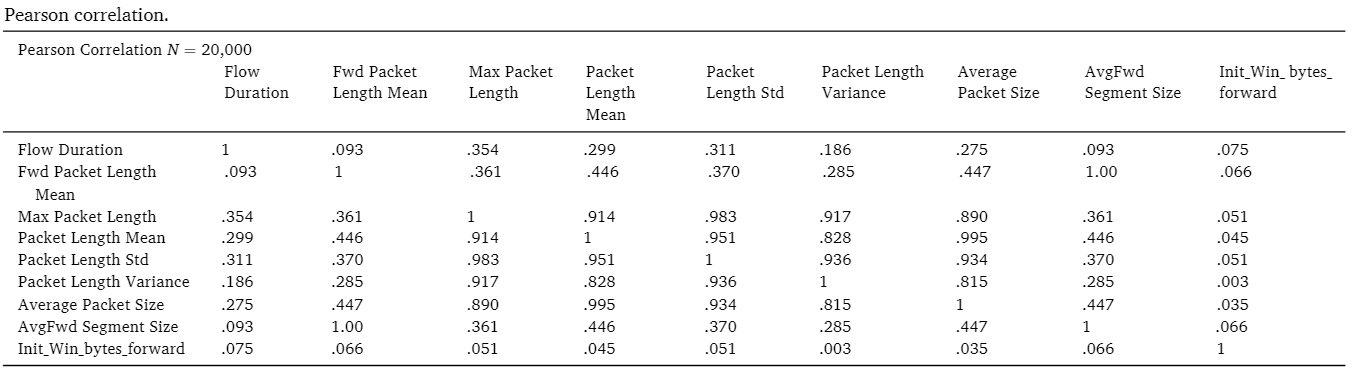

In [4]:
Image("./features_pearson_correlation.png")

### Brief explanation of every feature
Flow Duration - the duration (in milliseconds) taken by the flow of packets in a packet sequence  

Fwd Packet Length Mean - the average length of packets (in bytes) sent in the client-server direction 
(forward direction)  

Max Packet Length - the maximum length of packets (in bytes) within the whole packet sequence  

Packet Length Mean - similar to Fwd Packet Length Mean, but in both directions  

Packet Length Std - the standard deviation of the packets withing the flow  

Packet Length Variance - the same as Packet Length Std but variance  

Average Packet Size - the mean size of the packets (in bytes) withind a packet sequence  

Avg Fwd Segment Size - the average size of the packets sent in the forward direction, but the headers are excluded  

Init_Win_bytes_forward - The number of bytes set in the initial window size in the forward direction. This is a part of the TCP protocol

Label - assigned label to every packet. Either DDoS or BENIGN (friendly)

In [89]:
# remove unnecessary spaces from dataset's column names
ddos_mapper = lambda x : x.strip()
ddos = ddos.rename(mapper=ddos_mapper, axis=1)

# feature selection
selected_features = ["Flow Duration",
                     "Fwd Packet Length Mean",
                     "Max Packet Length",
                     "Packet Length Mean",
                     "Packet Length Std",
                     "Packet Length Variance",
                     "Average Packet Size", 
                     "Avg Fwd Segment Size",
                     "Init_Win_bytes_forward",
                     "Label"
                    ]

ddos = ddos[selected_features]
ddos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225745 entries, 0 to 225744
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Flow Duration           225745 non-null  int64  
 1   Fwd Packet Length Mean  225745 non-null  float64
 2   Max Packet Length       225745 non-null  int64  
 3   Packet Length Mean      225745 non-null  float64
 4   Packet Length Std       225745 non-null  float64
 5   Packet Length Variance  225745 non-null  float64
 6   Average Packet Size     225745 non-null  float64
 7   Avg Fwd Segment Size    225745 non-null  float64
 8   Init_Win_bytes_forward  225745 non-null  int64  
 9   Label                   225745 non-null  object 
dtypes: float64(6), int64(3), object(1)
memory usage: 17.2+ MB


# Data Preprocessing

### Data Cleaning

This step shows if there are NA or Inf values in the dataset

In [6]:
print("NA Test", "\n", "\n", ddos.isna().any(), "\n")
print("Infinity Values Test", "\n", "\n", ddos.drop(columns="Label").map(np.isinf).any())

NA Test 
 
 Flow Duration             False
Fwd Packet Length Mean    False
Max Packet Length         False
Packet Length Mean        False
Packet Length Std         False
Packet Length Variance    False
Average Packet Size       False
Avg Fwd Segment Size      False
Init_Win_bytes_forward    False
Label                     False
dtype: bool 

Infinity Values Test 
 
 Flow Duration             False
Fwd Packet Length Mean    False
Max Packet Length         False
Packet Length Mean        False
Packet Length Std         False
Packet Length Variance    False
Average Packet Size       False
Avg Fwd Segment Size      False
Init_Win_bytes_forward    False
dtype: bool


### Creating training, validation, and testing sets

In [7]:
ddos_main, _ = train_test_split(ddos, train_size=0.2)
ddos_training, ddos_other = train_test_split(ddos_main, train_size=0.5)
ddos_validation, ddos_test = train_test_split(ddos_other, test_size=0.5)

# Feature Engineering

SVM, KNearest Neighbours, and Logistic regression don't strictly require standartization or normalization. However, all algorithms will perform better because of their features:
- Logistic Regression uses Gradient Descent as its optimization algorithm. If during partial derivative usage with respect to features $w_1, w_2, w_D$ one of them had [0, 1000] range and others [0, 0.001], then the derivative with the respect to higher value will dominate.
- KNearest Neighbours uses Euclidean or cosine distance to determine the similarity of vector directions (Andriy Burkow, 2019). If one feature will have significantly larger scale, this feature will dominate the distance calulation.
- SVM measures the Euclidean norm between support vectors to set the hyperplane equally distant from the nearest data points of each class (Andriy Burkow, 2019). If one feature will dominate others, SVM can place the hyperplane in the favor of this feature, making others insignificant.

These are the reasons why model performances will be affected by feature scaling. First, the distributions of features will be displayed to visually understand the range of values. Then, the data will be normalized using MinMaxScaler from scikit-learn suggested by (Andriy Burkow, 2019).  

Normalization is also done on the separated training, validation, and test set since the formula of Min-Max normalization looks like this:

### $$
X' = \frac{X - X_{min}}{X_{max} - X_{min}}
$$

If the normalization were done prior to the three sets creation*, the results of the normalization would be wrong due to the differences in the highest and the lowest values withing the ddos_main and the three data sets.

array([[<Axes: title={'center': 'Flow Duration'}>,
        <Axes: title={'center': 'Fwd Packet Length Mean'}>,
        <Axes: title={'center': 'Max Packet Length'}>],
       [<Axes: title={'center': 'Packet Length Mean'}>,
        <Axes: title={'center': 'Packet Length Std'}>,
        <Axes: title={'center': 'Packet Length Variance'}>],
       [<Axes: title={'center': 'Average Packet Size'}>,
        <Axes: title={'center': 'Avg Fwd Segment Size'}>,
        <Axes: title={'center': 'Init_Win_bytes_forward'}>]], dtype=object)

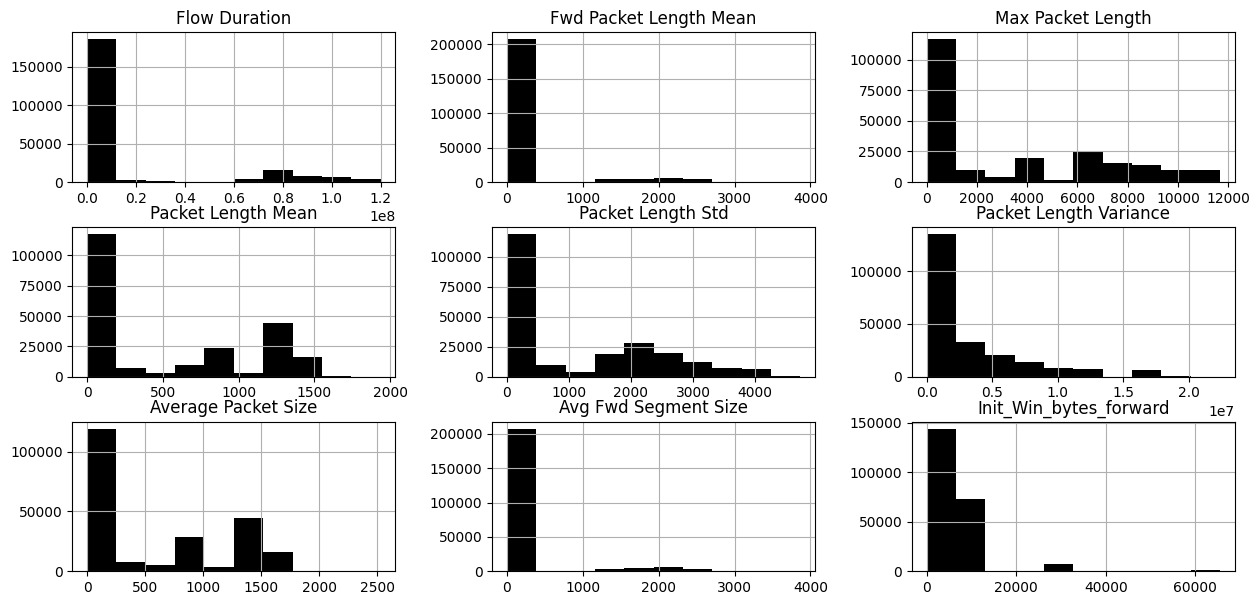

In [8]:
numerical_features = ["Flow Duration",
                     "Fwd Packet Length Mean",
                     "Max Packet Length",
                     "Packet Length Mean",
                     "Packet Length Std",
                     "Packet Length Variance",
                     "Average Packet Size", 
                     "Avg Fwd Segment Size",
                     "Init_Win_bytes_forward"
                    ]
ddos[numerical_features].hist(figsize=(15, 7), color="black")

In [9]:
scaler = MinMaxScaler()

### As it can be seen here, the ranges of features are now the same: $[0.0; 1.0]$  

array([[<Axes: title={'center': 'Flow Duration'}>,
        <Axes: title={'center': 'Fwd Packet Length Mean'}>,
        <Axes: title={'center': 'Max Packet Length'}>],
       [<Axes: title={'center': 'Packet Length Mean'}>,
        <Axes: title={'center': 'Packet Length Std'}>,
        <Axes: title={'center': 'Packet Length Variance'}>],
       [<Axes: title={'center': 'Average Packet Size'}>,
        <Axes: title={'center': 'Avg Fwd Segment Size'}>,
        <Axes: title={'center': 'Init_Win_bytes_forward'}>]], dtype=object)

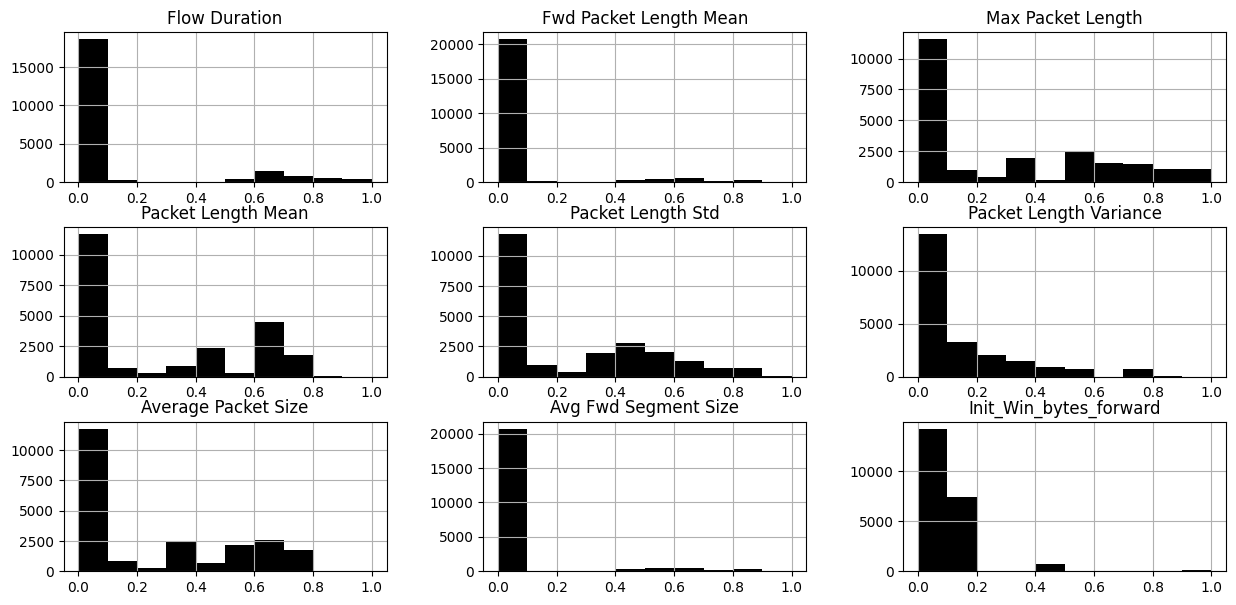

In [10]:
ddos_training[numerical_features] = scaler.fit_transform(ddos_training[numerical_features])
ddos_training[numerical_features].hist(figsize=(15, 7), color="black")

In [11]:
ddos_validation[numerical_features] = scaler.fit_transform(ddos_validation[numerical_features])
ddos_test[numerical_features] = scaler.fit_transform(ddos_test[numerical_features])

### In this computation, I drop the label column "Label" to create the X vector, and I assign the same column to the Y vector

In [12]:
# training x and y vectors
ddos_training_X = ddos_training.drop(columns="Label")
ddos_training_Y = ddos_training["Label"]

# validation x and y vectors
ddos_validation_X = ddos_validation.drop(columns="Label")
ddos_validation_Y = ddos_validation["Label"]

# test x and y vectors
ddos_test_X = ddos_test.drop(columns="Label")
ddos_test_Y = ddos_test["Label"]

### Two plots below indicate that the distribution of the Y labels is the same before and after the three sets creation.

In [13]:
# created function to not repeat the same plotting code
def display_label_counts(dt, label):
    label_counts = dt[label].value_counts()
    plt.bar(label_counts.index, label_counts.values, color="black")

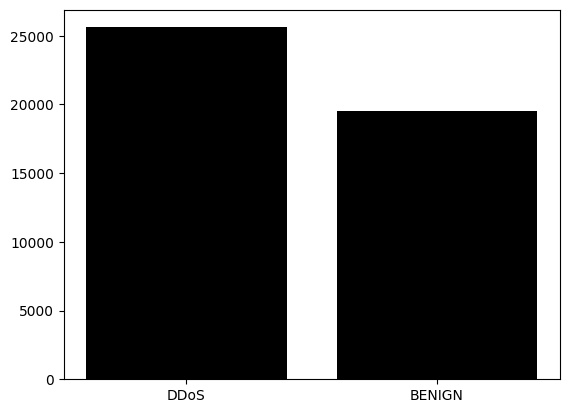

In [14]:
display_label_counts(ddos_main, "Label")

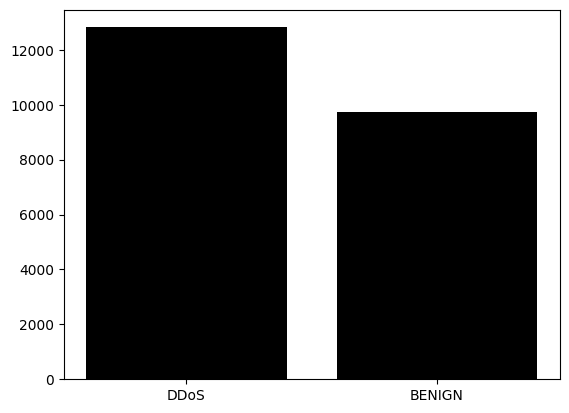

In [15]:
display_label_counts(ddos_training, "Label")

# Model Training and Hyperperemeter Tuning: Training Set

# SVM

### Since hyperparameter tuning is too heavy to compute on the whole training set, a sample from the set will be taken and used.

In [16]:
training_sample_X, _, training_sample_Y, _ = train_test_split(ddos_training_X, ddos_training_Y, test_size=0.9)
training_sample_X

,Flow Duration,Fwd Packet Length Mean,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,Average Packet Size,Avg Fwd Segment Size,Init_Win_bytes_forward
94780,0.688032,0.571429,0.377749,0.354581,0.288736,0.083321,0.313952,0.571429,0.003510
60435,0.638267,0.894357,0.755498,0.495895,0.488260,0.238263,0.442764,0.894357,0.003510
213807,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005463
79012,0.082953,0.002068,0.000517,0.003098,0.000000,0.000000,0.003012,0.002068,0.003510
8987,0.006267,0.019816,0.012937,0.041614,0.009054,0.000082,0.043348,0.019816,0.000000
...,...,...,...,...,...,...,...,...,...
176564,0.834747,0.666667,0.503665,0.354763,0.362831,0.131571,0.314113,0.666667,0.003510
9404,0.087608,0.120157,0.156102,0.169045,0.131164,0.017194,0.149675,0.120157,0.125015
54358,0.008972,0.002987,1.000000,0.750774,0.866008,0.750000,0.715023,0.002987,0.125015
88021,0.083940,0.002068,0.000517,0.003098,0.000000,0.000000,0.002904,0.002068,0.003510


In [17]:
SVM_model = SVC()

In [81]:
SVM_grid = {
    # C values were chosen experimentally by iteratively running grid search
    "C": [2, 5, 10],
    "kernel": ["linear", "rbf"],
    "gamma": ["scale", "auto"]
}

SVM_grid_search = GridSearchCV(estimator=SVM_model, param_grid=SVM_grid, scoring="accuracy", n_jobs=-1)
SVM_grid_search.fit(training_sample_X, training_sample_Y)

print("Best Parameters:", SVM_grid_search.best_params_)
print("Best Cross-Validation Score:", SVM_grid_search.best_score_)

Best Parameters: {'C': 5, 'gamma': 'scale', 'kernel': 'rbf'}
Best Cross-Validation Score: 0.9153807664383965


In [82]:
SVM_model = SVC(C=15, kernel="rbf", gamma="scale")
SVM_model.fit(ddos_training_X, ddos_training_Y)

SVC(C=15)

# KNN

In [20]:
KNN_model = KNeighborsClassifier()

In [46]:
KNN_grid = {
    # values were chosen experimentally by iteratively running grid search
    "n_neighbors": [1, 2, 5],
    "weights": ["uniform", "distance"],
    "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
    "leaf_size": [1, 5, 10]
}

KNN_grid_search = GridSearchCV(estimator=KNN_model, param_grid=KNN_grid, scoring="accuracy", n_jobs=-1)
KNN_grid_search.fit(training_sample_X, training_sample_Y)

print("Best Parameters:", KNN_grid_search.best_params_)
print("Best Cross-Validation Score:", KNN_grid_search.best_score_)

Best Parameters: {'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 1, 'weights': 'uniform'}
Best Cross-Validation Score: 0.9610128917057473


In [47]:
KNN_model = KNeighborsClassifier(n_neighbors=1, weights="uniform", algorithm="auto", leaf_size=1)

In [48]:
KNN_model.fit(ddos_training_X, ddos_training_Y)

KNeighborsClassifier(leaf_size=1, n_neighbors=1)

In [24]:
KNN_Y_predict = KNN_model.predict(ddos_test_X)

In [25]:
KNN_precision = precision_score(ddos_test_Y, KNN_Y_predict, pos_label="DDoS")
KNN_precision

np.float64(0.9090909090909091)

# Logistic Regression

In [26]:
LR_model = LogisticRegression(penalty="l2")

In [27]:
LR_grid = {
    "solver": ["sag", "saga", "liblinear"],
    "tol": [0.00001 ,0.0001, 0.001],
    "C": [1.0, 2.0, 3.0]
}

LR_grid_search = GridSearchCV(estimator=LR_model, param_grid=LR_grid, scoring="accuracy", n_jobs=-1)
LR_grid_search.fit(ddos_training_X, ddos_training_Y)

print("Best Parameters:", LR_grid_search.best_params_)
print("Best Cross-Validation Score:", LR_grid_search.best_score_)

Best Parameters: {'C': 1.0, 'solver': 'sag', 'tol': 1e-05}
Best Cross-Validation Score: 0.7936122048741188


In [28]:
LR_model = LogisticRegression(penalty="l2", C=2.0, solver="liblinear", tol=0.001)

In [29]:
LR_model.fit(ddos_training_X, ddos_training_Y)

LogisticRegression(C=2.0, solver='liblinear', tol=0.001)

In [30]:
LR_Y_prediction = LR_model.predict(ddos_test_X)

In [31]:
LR_precision = precision_score(ddos_test_Y, LR_Y_prediction, pos_label="DDoS")
LR_precision

np.float64(0.9559512652296157)

# Model Validation: Validation Set

In this section, the models try to predict yet unknnown values from the validation set to test their performances with hyperparameter tuning.

# SVM

In [83]:
SVM_Y_validation = SVM_model.predict(ddos_validation_X)

In [84]:
SVM_validation_precision = precision_score(ddos_validation_Y, SVM_Y_validation, pos_label="DDoS")
SVM_validation_precision

np.float64(0.9119318181818182)

# KNN

In [34]:
KNN_Y_validation = KNN_model.predict(ddos_validation_X)

In [35]:
KNN_validation_precision = precision_score(ddos_validation_Y, KNN_Y_validation, pos_label="DDoS")
KNN_validation_precision

np.float64(0.9841121495327103)

# Logistic Regression

In [36]:
LR_Y_validation = LR_model.predict(ddos_validation_X)

In [37]:
LR_validation_precision = precision_score(ddos_validation_Y, LR_Y_validation, pos_label="DDoS")
LR_validation_precision

np.float64(0.9609652235628106)

### As the result of the validation, the KNN model showed the best result!

Next, a new instance of KNN model will be trained on training and validation sets and then evaluated on the test set.

# Model Training and Assessment: Training + Validation Sets, Test Set

# Model Training

In [49]:
KNN = KNeighborsClassifier(n_neighbors=1, weights="uniform", algorithm="auto", leaf_size=1)

In [51]:
KNN.fit(ddos_training_X, ddos_training_Y)
KNN.fit(ddos_validation_X, ddos_validation_Y)

KNeighborsClassifier(leaf_size=1, n_neighbors=1)

In [52]:
KNN_test_prediction = KNN.predict(ddos_test_X)

In [56]:
KNN_test_precision = precision_score(ddos_test_Y, KNN_test_prediction, pos_label="DDoS")
KNN_test_precision

np.float64(0.9920436817472699)

# Model Assessment

### Confustion Matrix

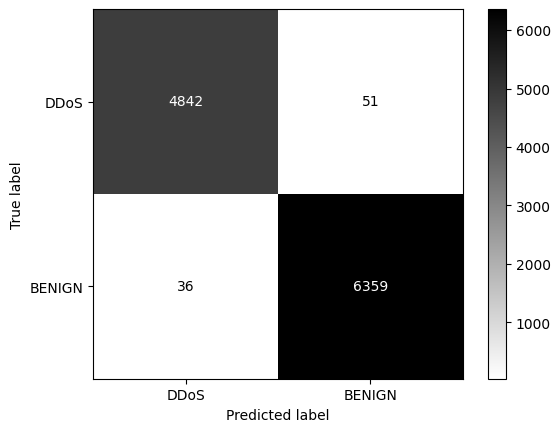

In [69]:
matrix = confusion_matrix(ddos_test_Y, KNN_test_prediction)

matrix_plot = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=["DDoS", "BENIGN"])
matrix_plot.plot(cmap=plt.cm.binary)
plt.show()

### ROC-AUC

In [71]:
KNN_test_probability = KNN.predict_proba(ddos_test_X)[:, 1]

AUC Score: 0.9919737743456649


Text(0.5, 1.0, 'Receiver Operating Characteristic (ROC) Curve')

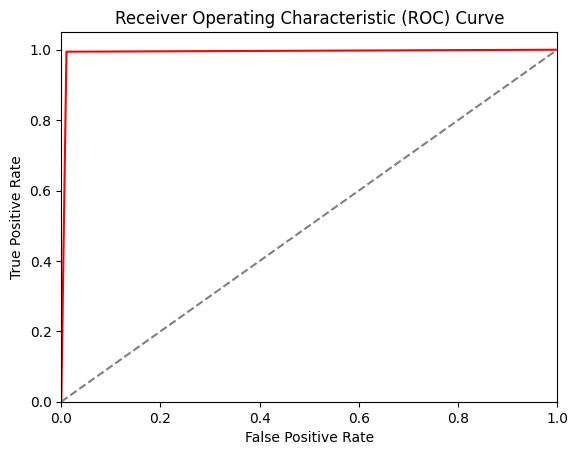

In [76]:
fpr, tpr, thresholds = roc_curve(ddos_test_Y, KNN_test_probability, pos_label="DDoS") 

auc_score = roc_auc_score(ddos_test_Y, KNN_test_probability)
print(f"AUC Score: {auc_score}")

plt.figure()
plt.plot(fpr, tpr, color='red', label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Dashed diagonal line (random guessing)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')

# Conclusion

The performance of all ML models was brilliant. However, KNN performed much better than other ML models and showed the most excellent results. Metrics such as ROC-AUC show that the created KNN classifier is almost perfect. I suggest that it performed better since it is non-parametric algorithm, looks for local matches in data, and can deal with complex data distributions. SVM assumes some particular distribution of data. It doesn't necessairly have to be linear data.

# References

Andriy Burkow (2019). The Hundred-Page Machine Learning Book.

Chanu, U.S., Singh, K.J. and Chanu, Y.J. eds., (2023). A dynamic feature selection technique to detect DDoS attack. [online] ScienceDirect.  
Available at: https://www.sciencedirect.com/science/article/abs/pii/S2214212623000303.

www.ibm.com, (2023). What Is Support Vector Machine? [online] Available at: https://www.ibm.com/topics/support-vector-machine